# Limit/average values of Lagrangian/Eulerian diffusivity as a function of slope

In [1]:
import numpy as np
import pandas as pd
from itertools import product
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.ticker import SymmetricalLogLocator, NullFormatter
from matplotlib.gridspec import GridSpec
import cmocean as cmo
import seaborn as sns
sns.set_style('darkgrid')

In [2]:
def addTicks(ax,base,linthresh):
    ax.xaxis.set_major_locator(SymmetricalLogLocator(base=base, linthresh=linthresh))
    subs = np.arange(2, 10) * 0.1
    ax.xaxis.set_minor_locator(SymmetricalLogLocator(base=base, subs=subs, linthresh=linthresh))
    ax.xaxis.set_minor_formatter(NullFormatter())

    # Filter out ticks inside the linear region
    major_ticks = [t for t in ax.get_xticks() if abs(t) >= linthresh]
    minor_ticks = [t for t in ax.get_xticks(minor=True) if abs(t) >= linthresh]

    major_ticks.extend([-linthresh, linthresh])
    major_ticks = sorted(set(major_ticks))  # remove duplicates and sort

    ax.set_xticks(major_ticks)
    ax.set_xticks(minor_ticks, minor=True)
    ax.tick_params(which="both", bottom=True)

In [3]:
g = 9.81
f0 = 1e-4
rho1 = 1027.6
rho2 = 1028
gp = g*(rho2-rho1)/rho2
H1 = 1000
H2 = 4000
U = 0.2
alpha_c = f0*U/gp

F1 = f0**2/(gp*H1)
F2 = f0**2/(gp*H2)

In [4]:
print(F1)
print(F2)

2.6197757390411983e-09
6.549439347602996e-10


In [5]:
g = 9.81
f0 = 1e-4
rho1 = 1027.6
rho2 = 1028
gp = g*(rho2-rho1)/rho2
U = 0.2

H = {'1':1000, '2':4000} # layer depths
L_Rossby = {layer:np.sqrt(gp*H[layer])/f0 for layer in H.keys()}


def dQdy(slope,layer):
    F = 1/L_Rossby[layer]**2

    if layer=='1':
        return F*U
    elif layer=='2':
        return -F*U + f0/H[layer]*float(slope)

In [6]:
# diffusivity measures

# Lagrangian: integral of autocorrelation of cross-stream Lagrangian velocity, using the biased autocorrelation
def load_diff_lagr(slope,layer,field,filtertype='_highqfilter'):
    file = '../../Results/Results_Diffusivities/SmallLd/lagrangian/acov_diff_s'+slope+'_layer'+layer+'_field'+field+'_1hr12hr_biased'+filtertype+'.csv'
    return pd.read_csv(file)

def limitDiff_lagr(slope,layer,field,days,run=None,filtertype='_highqfilter'):
    if field=='all': # consider all fields
        diff_1 = load_diff_lagr(slope,layer,'1',filtertype=filtertype)
        diff_2 = load_diff_lagr(slope,layer,'2',filtertype=filtertype)
        diff_3 = load_diff_lagr(slope,layer,'3',filtertype=filtertype)
        diff = pd.concat([diff_1,diff_2,diff_3],axis=0)
        diff_end = diff.iloc[:,int(-days*2):] # for each particle run, last X days
    elif run==None: # consider only one field
        diff = load_diff_lagr(slope,layer,field,filtertype=filtertype)
        diff_end = diff.iloc[:,int(-days*2):]
    else: # consider only one field and one particle run
        diff = load_diff_lagr(slope,layer,field,filtertype=filtertype).iloc[run]
        diff_end = diff.iloc[int(-days*2):]
    limdiff = np.nanmean(diff_end.to_numpy()) # average over last X days over all particle runs
    limstd = np.nanstd(diff_end.to_numpy()) # standard deviation over last X days over all particle runs
    return limdiff, limstd



# Eulerian: flux-gradient relation of PV field
def load_diff_eulr(slope,layer,field):
    file = '../../Results/Results_Diffusivities/SmallLd/eulerian/simulation_s'+slope+'_field'+field+'_layer'+layer+'_diff.csv'
    return pd.read_csv(file)

def limitDiff_eulr(slope,layer,field):
    if field=='all': # average over all fields
        diff_1 = load_diff_eulr(slope,layer,'1')
        diff_2 = load_diff_eulr(slope,layer,'2')
        diff_3 = load_diff_eulr(slope,layer,'3')
        diff = pd.concat([diff_1,diff_2,diff_3],axis=0)
    else: # consider only one field
        diff = load_diff_eulr(slope,layer,field)
    limdiff = np.nanmean(diff.to_numpy()) # average over all times
    limstd = np.nanstd(diff.to_numpy()) # standard deviation over all times
    return limdiff, limstd

In [7]:
# ratio of lower/upper layer Lagrangian diffusivity

def ratio12_lagr(slope,field,days,filtertype='_highqfilter'):
    layer1 = load_diff_lagr(slope,'1',field,filtertype=filtertype)
    layer2 = load_diff_lagr(slope,'2',field,filtertype=filtertype)
    return layer2/layer1

def limitRatio12_lagr(slope,field,days,filtertype='_highqfilter'):
    if field=='all': # consider all fields
        ratio_1 = ratio12_lagr(slope,'1',days,filtertype=filtertype)
        ratio_2 = ratio12_lagr(slope,'2',days,filtertype=filtertype)
        ratio_3 = ratio12_lagr(slope,'3',days,filtertype=filtertype)
        ratio = pd.concat([ratio_1,ratio_2,ratio_3],axis=0)
    else: # consider only one field
        ratio = ratio12_lagr(slope,field,days,filtertype=filtertype)
    ratio_end = ratio.iloc[:,int(-days*2):] # for each particle run, last X days
    limratio = np.nanmean(ratio_end.to_numpy()) # average over last X days over all particle runs
    limstd = np.nanstd(ratio_end.to_numpy()) # standard deviation over last X days over all particle runs
    return limratio, limstd


def ratio12_eulr(slope,field):
    layer1 = load_diff_eulr(slope,'1',field)
    layer2 = load_diff_eulr(slope,'2',field)
    return layer2/layer1

def limitRatio12_eulr(slope,field):
    if field=='all': # average over all fields
        ratio_1 = ratio12_eulr(slope,'1')
        ratio_2 = ratio12_eulr(slope,'2')
        ratio_3 = ratio12_eulr(slope,'3')
        ratio = pd.concat([ratio_1,ratio_2,ratio_3],axis=0)
    else: # consider only one field
        ratio = ratio12_eulr(slope,field)
    limratio = np.nanmean(ratio.to_numpy()) # average over all times
    limstd = np.nanstd(ratio.to_numpy()) # standard deviation over all times
    return limratio, limstd

In [8]:
1/limitRatio12_lagr('0','all',100)[0]

np.float64(1.385595857344637)

## Plotting the diffusivity as a function of slope

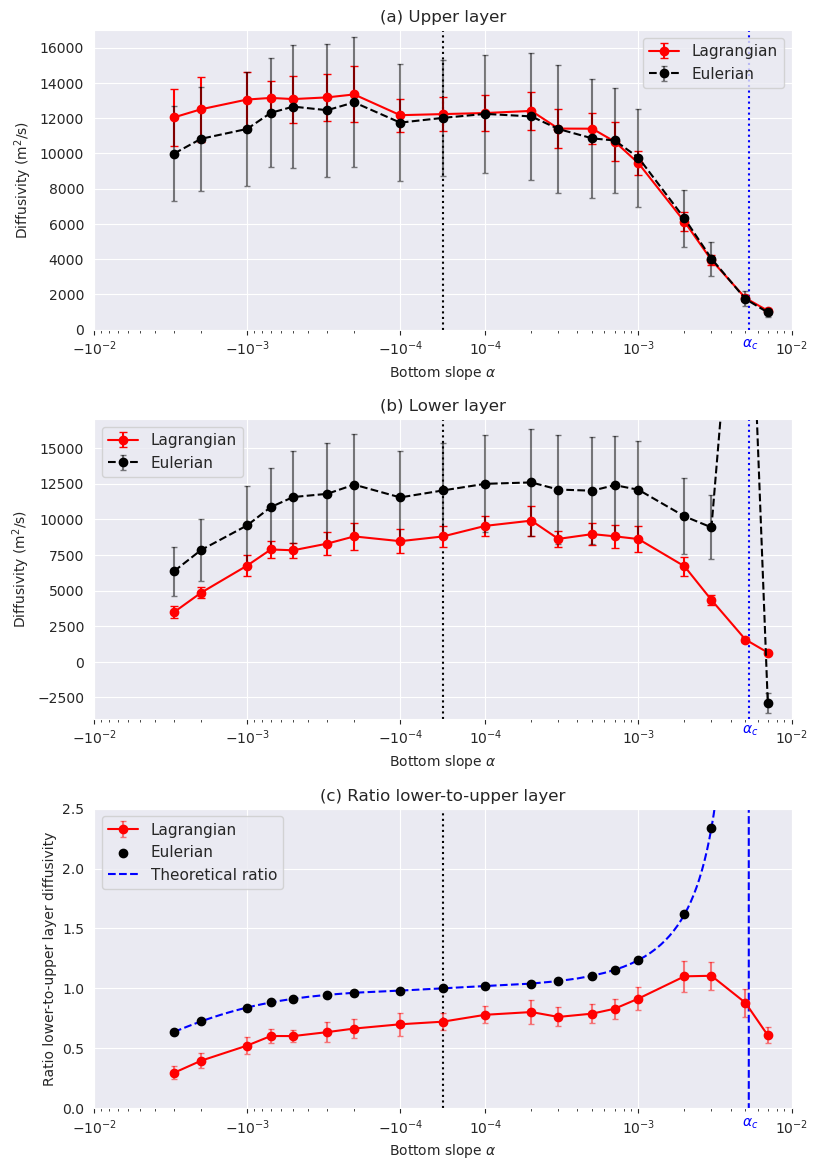

In [ ]:
slopes = ['-3e-3','-2e-3','-1e-3','-7e-4','-5e-4','-3e-4','-2e-4','-1e-4',
            '0','1e-4','2e-4','3e-4','5e-4','7e-4','1e-3','2e-3','3e-3','5e-3','7e-3']
slopes_float = [float(s) for s in slopes]

def diff_vs_slope(layer,field,ax,days=100,show_err=True,logscale=False):
    """
    Plot average diffusivity as a function of slope
    """
    ax.axvline(0,color='k',linestyle=':')
    diff_lagr = []
    std_lagr = []
    diff_eulr = []
    std_eulr = []
    for slope in slopes:
        diff_l, std_l = limitDiff_lagr(slope,layer,field,days)
        diff_e, std_e = limitDiff_eulr(slope,layer,field)
        diff_lagr.append(diff_l)
        std_lagr.append(std_l)
        diff_eulr.append(diff_e)
        std_eulr.append(std_e)
    if show_err:
        ax.errorbar(slopes_float,diff_lagr,yerr=std_lagr,capsize=3,marker='o',label='Lagrangian',color='r',ecolor=mcolors.to_rgba('r',1))
        ax.errorbar(slopes_float,diff_eulr,yerr=std_eulr,capsize=2,marker='o',label='Eulerian',color='k',ecolor=mcolors.to_rgba('k',0.5),linestyle='dashed')
    else:
        ax.plot(slopes_float,diff_lagr,marker='o',label='Lagrangian',color='r')
        ax.plot(slopes_float,diff_eulr,marker='o',label='Eulerian',color='k')
    ax.legend(fontsize=11)
    ax.set_xlabel(r'Bottom slope $\alpha$')
    ax.set_ylabel(r'Diffusivity (m$^2$/s)')
    ax.set_xscale('symlog', linthresh=1e-4, linscale=0.25)
    addTicks(ax,10,1e-4)
    ax.set_xlim(-1e-2, 1e-2)
    if logscale:
        ax.set_yscale('log')

def diff_vs_slope_ratio_upperlower(field,ax,days=100,show_err=True):
    """
    For each particle run, compute the ratio between the upper and lower layer diff.
    Compute the average and std of those numbers.
    """
    ax.axvline(0,color='k',linestyle=':')
    ratio_lagr = []
    std_lagr = []
    ratio_eulr = []
    std_eulr = []
    for slope in slopes:
        ratio_l, std_l = limitRatio12_lagr(slope,field,days)
        ratio_e, std_e = limitRatio12_eulr(slope,field)
        ratio_lagr.append(ratio_l)
        std_lagr.append(std_l)
        ratio_eulr.append(ratio_e)
        std_eulr.append(std_e)
    if show_err:
        plot_lagr = ax.errorbar(slopes_float,ratio_lagr,yerr=std_lagr,capsize=2,marker='o',label='Lagrangian',color='r',ecolor=mcolors.to_rgba('r',0.5))
        plot_eulr = ax.scatter(slopes_float,ratio_eulr,marker='o',label='Eulerian',color='k',zorder=10)#,ecolor=mcolors.to_rgba('k',0.5))
    else:
        ax.plot(slopes_float,ratio_lagr,marker='o',color='r',label='Lagrangian')
    ax.legend(fontsize=11)
    ax.set_xlabel(r'Bottom slope $\alpha$')
    ax.set_ylabel(r'Ratio lower-to-upper layer diffusivity')
    ax.set_xscale('symlog', linthresh=1e-4, linscale=0.25)
    addTicks(ax,10,1e-4)
    ax.set_xlim(-1e-2, 1e-2)
    return plot_lagr, plot_eulr

def theoretical_ratio(slope):
    ratio = 1/(1 - slope/alpha_c)
    return ratio


fig, (ax1,ax2,ax3) = plt.subplots(3,1,figsize=(9,14))

field = 'all'
diff_vs_slope('1',field,ax1,show_err=True)
diff_vs_slope('2',field,ax2,show_err=True)

ax1.set_title('(a) Upper layer')
ax2.set_title('(b) Lower layer')
ax3.set_title('(c) Ratio lower-to-upper layer')

ax1.set_ylim(0,17000)
ax2.set_ylim(-4000,17000)
ax3.set_ylim(0,2.5)

slope_array = np.arange(-3e-3,7e-3,1e-4)
plot_lagr, plot_eulr = diff_vs_slope_ratio_upperlower(field,ax3,show_err=True)
plot_ratio = ax3.plot(slope_array,theoretical_ratio(slope_array),color='b',linestyle='--',label='Theoretical ratio')
handles, labels = ax3.get_legend_handles_labels()
order = [2,0,1]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], fontsize=11)

# indicate the critical slope
ax1.text(alpha_c-5e-4,-1000,r'$\alpha_c$',color='b')
ax1.vlines(alpha_c,ax1.get_ylim()[0],ax1.get_ylim()[1],color='b',linestyle=':')
ax2.text(alpha_c-5e-4,-5000,r'$\alpha_c$',color='b')
ax2.vlines(alpha_c,ax2.get_ylim()[0],ax2.get_ylim()[1],color='b',linestyle=':')
ax3.text(alpha_c-5e-4,-0.15,r'$\alpha_c$',color='b')

plt.subplots_adjust(hspace=0.3, wspace=0.3)
#plt.savefig('../../Figures/diff_vs_slope.pdf', bbox_inches='tight')
plt.show()

## For Lagrangian diffusivity: check effect of filtering trapped particles

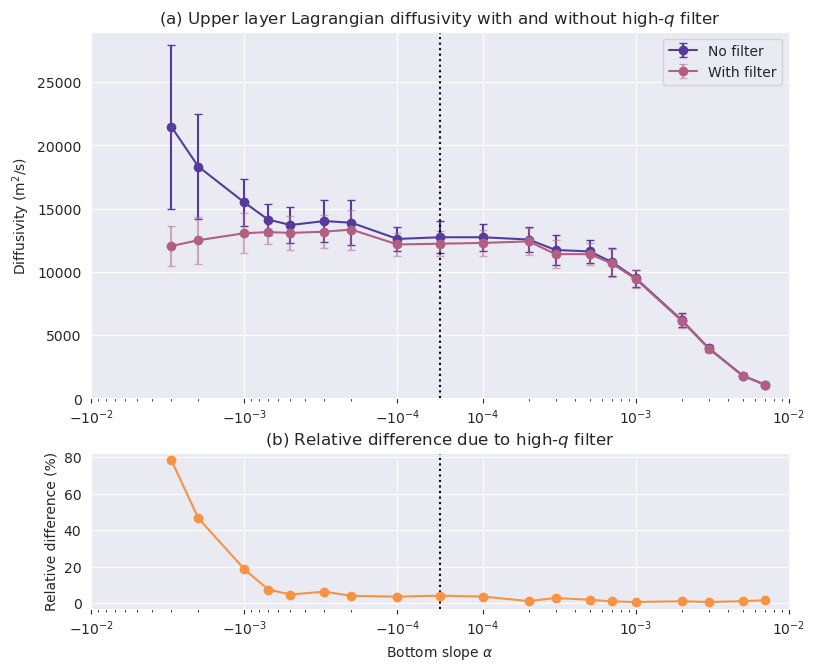

In [ ]:
slopes = ['-3e-3','-2e-3','-1e-3','-7e-4','-5e-4','-3e-4','-2e-4','-1e-4',
            '0','1e-4','2e-4','3e-4','5e-4','7e-4','1e-3','2e-3','3e-3','5e-3','7e-3']
slopes_float = [float(s) for s in slopes]

cmap = matplotlib.colormaps.get_cmap('cmo.thermal')
colors = cmap(np.linspace(0.25,0.75,3))

layer = '1'
field = 'all'
days = 100
fig = plt.figure(figsize=(9,7.5))
gs = GridSpec(3,1,hspace=0.35)
ax1 = fig.add_subplot(gs[0:2,:])
ax2 = fig.add_subplot(gs[2,:])

diff_lagr_nofilter = []
std_lagr_nofilter = []
diff_lagr = []
std_lagr = []
for slope in slopes:
    diff_l_f, std_l_f = limitDiff_lagr(slope,layer,field,days,filtertype='')
    diff_lagr_nofilter.append(diff_l_f)
    std_lagr_nofilter.append(std_l_f)
    diff_l, std_l = limitDiff_lagr(slope,layer,field,days)
    diff_lagr.append(diff_l)
    std_lagr.append(std_l)
ax1.errorbar(slopes_float,diff_lagr_nofilter,yerr=std_lagr_nofilter,capsize=3,marker='o',label='No filter',color=colors[0],ecolor=mcolors.to_rgba(colors[0],1))
ax1.errorbar(slopes_float,diff_lagr,yerr=std_lagr,capsize=3,marker='o',label='With filter',color=colors[1],ecolor=mcolors.to_rgba(colors[1],0.5))
ax1.legend()#(fontsize=11)
ax1.set_ylim(0,29000)
ax1.set_ylabel(r'Diffusivity (m$^2$/s)')

ratio_filter = (np.array(diff_lagr_nofilter) - np.array(diff_lagr)) / np.array(diff_lagr) * 100
ax2.plot(slopes_float, ratio_filter, marker='o', color=colors[2],zorder=10)
ax2.set_ylabel(r'Relative difference (%)')
ax2.set_xlabel(r'Bottom slope $\alpha$')

for ax in [ax1,ax2]:
    ax.axvline(0,color='k',linestyle=':')
    ax.set_xscale('symlog', linthresh=1e-4, linscale=0.25)
    addTicks(ax,10,1e-4)
    ax.set_xlim(-1e-2, 1e-2)

ax1.set_title(r'(a) Upper layer Lagrangian diffusivity with and without high-$q$ filter')
ax2.set_title(r'(b) Relative difference due to high-$q$ filter')

#plt.savefig('../../Figures/diff_vs_slope_filter.pdf', bbox_inches='tight')
plt.show()